# TensorFlow for Deep Learning - Convolutional Neural Networks

Credits - [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

## How Computers Interpret Images

[<img src="images/ImageWComputers.png" width="500"/>](https://youtu.be/mEPfoM68Fx4)

## Local Connectivity

[<img src="images/LocalConnectivity_1.png" width="500"/>](https://youtu.be/z9wiDg0w-Dc)
[<img src="images/LocalConnectivity_2.png" width="500"/>](https://youtu.be/z9wiDg0w-Dc)

**Why not simply use a deep neural network with fully connected layers for image recognition tasks?**

Unfortunately, although this works fine for small images (e.g., MNIST), it breaks down for larger images because of the huge number of parameters it requires. For example, a 100 x 100 -pixel image has 10,000 pixels, and if the first layer has just 1,000 neurons (which already severely restricts the amount of information transmitted to the next layer), this means a total of 10 million connections. And that's just the first layer. CNNs solve this problem using partially connected layers and weight
sharing.

## Convolutional Layers

<img src="images/TF_CNN1.png" width="400"/>
<img src="images/TF_CNN2.png" width="348"/>
<img src="images/TF_CNN3.png" width="373"/>

**Local receptive fields**: the most important building block of a CNN is the _convolutional layer_: neurons in the first convolutional layer are not connected to every single pixel in the input image (like they were in the layers of DNN earlier), but only to pixels in their receptive fields. In turn, each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer. This architecture allows the network to concentrate on small low-level features in the first hidden layer, then assemble them into larger higher-level features in the next hidden layer, and so on. This hierarchical structure is common in real-world images, which is one of the reasons why CNNs work so well for image recognition.

**Zero Padding**: a neuron located in row i, column j of a given layer is connected to the outputs of the neurons in the previous layer located in rows i to i + fh - 1, columns j to j + fw - 1, where fh  and fw  are the height and width of the receptive field. In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs. This is called zero padding.
    
- <img src="images/TF_CNN7.png" width="400"/>

- If set to "SAME", the convolutional layer uses zero padding if necessary. The output size is set to the number of input neurons divided by the stride, rounded up. For example, if the input size is 13 and the stride is 5 then the output size is 3 (i.e., 13 / 5 = 2.6, rounded up to 3). Then zeros are added as evenly as possible around the inputs, as needed. When strides=1, the layer's outputs will have the same spatial dimensions (width and height) as its inputs, hence the name same.
- If set to "VALID", the convolutional layer does not use zero padding and may ignore some rows and columns at the bottom and right of the input image, depending on the stride. This means that every neuron's receptive field lies strictly within valid positions inside the input (it does not go out of bounds), hence the name valid.

**Stride**: it is possible to connect a large input layer to a much smaller layer by spacing out the receptive fields. This dramatically reduces the model's computational complexity. The shift from one receptive field to the next is called the stride. A 5x7 input layer (plus zero padding) is connected to a 3x4 layer, using 3x3 receptive fields and a stride of 2. 

<img src="images/TF_CNN4.png" width="430"/>
<img src="images/TF_CNN5.png" width="320"/>

**Filters**: a neuron's weights can be represented as a small image the size of the receptive field. For example, two possible sets of weights, called filters (or convolution kernels). The first one is represented as a black square with a vertical white line in the middle (it is a 7x7 matrix full of 0s except for the central column, which is full of 1s); neurons using these weights will ignore everything in their receptive field except for the central vertical line (since all inputs will get multiplied by 0, except for the ones located in the central vertical line). The second filter is a black square with a horizontal white line in the middle. Once again, neurons using these weights will ignore everything in their receptive field except for the central horizontal line.

Now if all neurons in a layer use the same vertical line filter (and the same bias term), and you feed the network the input image , the layer will output the top-left image. Notice that the vertical white lines get enhanced while the rest gets blurred.  Similarly, the upper-right image is what you get if all neurons use the same horizontal line filter; notice that the horizontal white lines get enhanced while the rest is blurred out. Thus, a layer full of neurons using the same filter outputs a feature map, which highlights the areas in an image that activate the filter the most. Of course, _you do not have to define the filters manually_: instead, during training the convolutional layer will "automatically learn the most useful filters for its task", and the layers above will learn to combine them into more complex patterns.

**Stacking Multiple Feature Maps**: usually a convolutional layer has multiple filters (you decide how many) and outputs one feature map per filter, so it is more accurately represented in higher dimensions. It has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters (i.e., the same weights and bias term i.e., $filter(f \times f) \times c_{in} + bias(1)$). Neurons in different feature maps use different parameters. A neuron's receptive field is the same as described earlier, but it extends across all the previous layers' feature maps. In short, a convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs.

- _CNN vs DNN_ : the fact that all neurons in a feature map share the same parameters dramatically reduces the number of parameters in the model. Once the CNN has learned to recognize a pattern in one location, it can recognize it in any other location. In contrast, once a regular DNN has learned to recognize a pattern in one location, it can recognize it only in that particular location.

<img src="images/TF_CNN6.png" width="400"/>

**Memory Requirements**: a problem with CNNs is that the convolutional layers require a huge amount of RAM. This is especially true during training, because the reverse pass of backpropagation requires all the intermediate values computed during the forward pass. 

- For example, consider a convolutional layer with 5x5 filters, outputting 200 feature maps of size 150x100, with stride 1 and "SAME" padding. If the input is a 150x100 RGB image (three channels), then the number of parameters is (5x5x3 + 1)x200 = 15,200 which is fairly small compared to a fully connected layer. However, each of the 200 feature maps contains 150x100 neurons, and each of these neurons needs to compute a weighted sum of its 5x5x3 = 75 inputs: that's a total of 225 million float multiplications. Not as bad as a fully connected layer, but still quite computationally intensive. Moreover, if the feature maps are represented using 32-bit floats, then the convolutional layer's output will occupy 200x150x100x32 = 96 million bits (12 MB) of RAM.  And that's just for one instance--if a training batch contains 100 instances, then this layer will use up 1.2 GB of RAM!
- During inference (i.e. prediction) the RAM occupied by one layer can be released as soon as the next layer has been computed, so you only need as much RAM as required by two consecutive layers. But during training everything computed during the forward pass needs to be preserved for the reverse pass, so the amount of RAM needed is (at least) the total amount of RAM required by all layers.

**TensorFlow Implementation** each input image is typically represented as a 3D tensor of shape [height, width, channels]. A mini-batch is represented as a 4D tensor of shape [mini-batch size, height, width, channels]. The weights of a convolutional layer are represented as a 4D tensor of shape [$f_h , f_w , f_{n^{'}} , f_n$]. The bias terms of a convolutional layer are simply  represented as a 1D tensor of shape [$f_n$].

In the following example we manually defined the filters, but in a real CNN you would normally define filters as trainable variables so the neural net can learn which filters work best.
```python
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, 
                           padding="same", activation="relu")
```                           

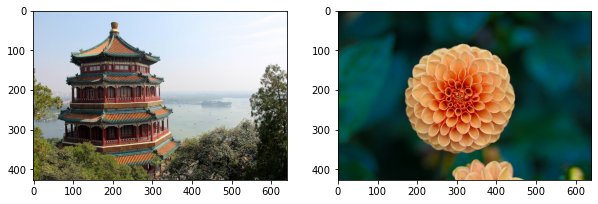

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_sample_image 
 
# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape 
 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
ax[0].imshow(china)
ax[1].imshow(flower) ;

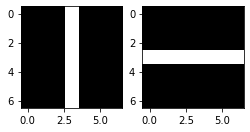

In [4]:
# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line   --> 1st filter
filters[3, :, :, 1] = 1  # horizontal line --> 2nd filter

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(4,4))
ax[0].imshow(filters[:,:,:,0])
ax[1].imshow(filters[:,:,:,1]);

Input shape: (2, 427, 640, 3), 
Conv2d-output shape: (2, 214, 320, 2)


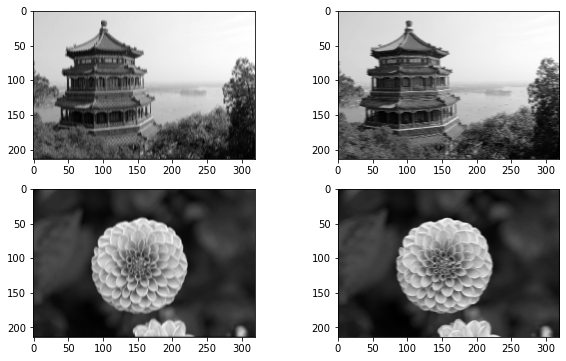

In [6]:
# Output of conv2d()
outputs = tf.nn.conv2d(images, filters, strides=2, padding="SAME") 
print(f"Input shape: {images.shape}, \nConv2d-output shape: {outputs.shape}")

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,6))
ax[0,0].imshow(outputs[0, :, :, 0], cmap="gray") # plot 1st image's 1st feature map
ax[0,1].imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map 
ax[1,0].imshow(outputs[1, :, :, 0], cmap="gray") # plot 2nd image's 1st feature map 
ax[1,1].imshow(outputs[1, :, :, 1], cmap="gray") # plot 2nd image's 2nd feature map 
plt.show()

**NOTE**: In this example we manually defined the filters, but in a real CNN you would normally define filters as trainable variables so the neural net can learn which filters work best.
```python
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, 
                           padding="same", activation="relu")
```                           

## Pooling Layers

<img src="images/TF_CNN8.png" width="550"/>
<img src="images/TF_CNN9.png" width="390"/>

**Advantages of Pooling**: 
- Their goal is to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting). 
- Just like in convolutional layers, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field. You must define its size, the stride, and the padding type, just like before. However, a pooling neuron has no weights; all it does is aggregate the inputs using an aggregation function such as the max or mean.
- Other than reducing computations, memory usage, and the number of parameters, a max pooling layer also introduces some level of invariance to small translations. Images B and C are the same as image A, but shifted by one and two pixels to the right. As you can see, the outputs of the max pooling layer for images A and B are identical. This is what translation invariance means. For image C, the output is different: it is shifted one pixel to the right (but there is still 75% invariance).
- By inserting a max pooling layer every few layers in a CNN, it is possible to get some level of translation invariance at a larger scale. Moreover, max pooling offers a small amount of rotational invariance and a slight scale invariance. Such invariance (even if it is limited) can be useful in cases where the prediction should not depend on these details, such as in classification tasks.

**Disadvantages of Pooling**: 
- it is obviously very destructive: even with a tiny 2x2 kernel and a stride of 2, the output will be two times smaller in both directions (so its area will be four times smaller), simply dropping 75% of the input values. And in some applications, invariance is not desirable. 
- Take semantic segmentation (the task of classifying each pixel in an image according to the object that pixel belongs to), obviously, if the input image is translated by one pixel to the right, the output should also be translated by one pixel to the right. The goal in this case is equivariance, not invariance: a small change to the inputs should lead to a corresponding small change in the output.

**Max vs Avg**:
- Average pooling layers used to be very popular, but people mostly use max pooling layers now, as they generally perform better. This may seem surprising, since computing the mean generally loses less information than computing the max. But on the other hand, max pooling preserves only the strongest features, getting rid of all the meaningless ones, so the next layers get a cleaner signal to work with. Moreover, max pooling offers stronger translation invariance than average pooling, and it requires slightly less compute.

**TensorFlow Implementation** :

```python
max_pool = keras.layers.MaxPool2D(pool_size=2)
max_pool = keras.layers.AvgPool2D(pool_size=2)
```                           

Input shape: (2, 427, 640, 3), 
Conv2d-output shape: (2, 214, 320, 2), 
Max pooling-output shape:(2, 72, 107, 2)
Avg pooling-output shape:(2, 72, 107, 2)


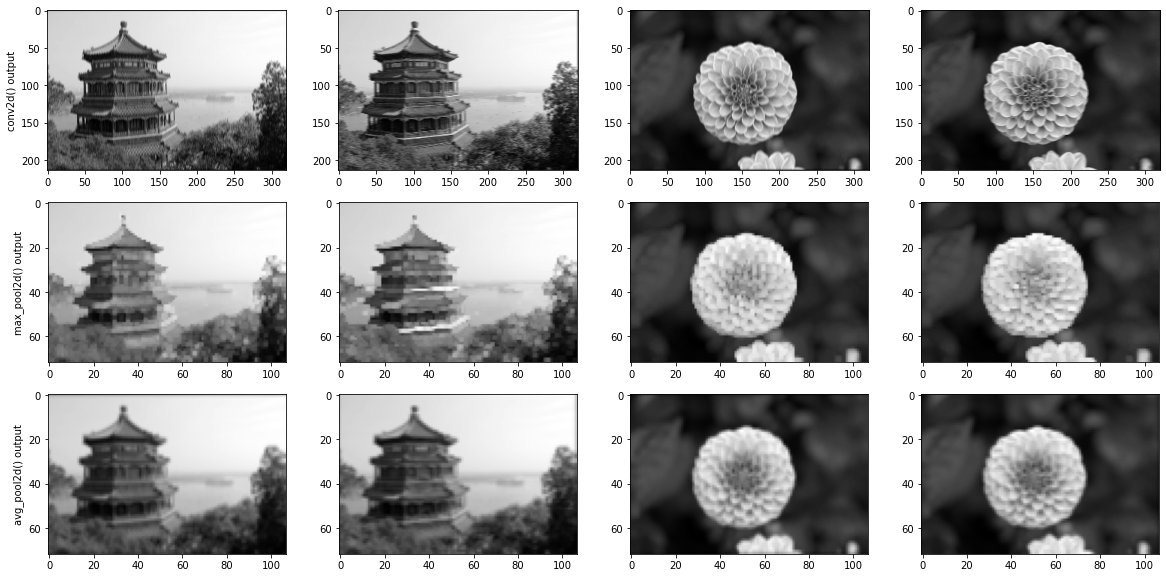

In [11]:
# Starting with previous output of conv2d() --> outputs
max_pooled_outputs = tf.nn.max_pool2d(outputs, ksize=5, strides=3, padding='SAME')
avg_pooled_outputs = tf.nn.avg_pool2d(outputs, ksize=5, strides=3, padding='SAME')
print(f"Input shape: {images.shape}, \nConv2d-output shape: {outputs.shape}, \nMax pooling-output shape:{max_pooled_outputs.shape}")
print(f"Avg pooling-output shape:{avg_pooled_outputs.shape}")

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(20,10))

ax[0,0].imshow(outputs[0, :, :, 0], cmap="gray") # plot 1st image's 1st feature map
ax[0,1].imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map 
ax[0,2].imshow(outputs[1, :, :, 0], cmap="gray") # plot 2nd image's 1st feature map 
ax[0,3].imshow(outputs[1, :, :, 1], cmap="gray") # plot 2nd image's 2nd feature map 

ax[1,0].imshow(max_pooled_outputs[0, :, :, 0], cmap="gray") # plot 1st image's 1st max pooled feature map
ax[1,1].imshow(max_pooled_outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd max pooled feature map 
ax[1,2].imshow(max_pooled_outputs[1, :, :, 0], cmap="gray") # plot 2nd image's 1st max pooled feature map 
ax[1,3].imshow(max_pooled_outputs[1, :, :, 1], cmap="gray") # plot 2nd image's 2nd max pooled feature map 

ax[2,0].imshow(avg_pooled_outputs[0, :, :, 0], cmap="gray") # plot 1st image's 1st avg pooled feature map
ax[2,1].imshow(avg_pooled_outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd avg pooled feature map 
ax[2,2].imshow(avg_pooled_outputs[1, :, :, 0], cmap="gray") # plot 2nd image's 1st avg pooled feature map 
ax[2,3].imshow(avg_pooled_outputs[1, :, :, 1], cmap="gray") # plot 2nd image's 2nd avg pooled feature map 

ax[0,0].set_ylabel("conv2d() output")
ax[1,0].set_ylabel("max_pool2d() output")
ax[2,0].set_ylabel("avg_pool2d() output")
plt.show();

## CNN Architectures

[<img src="images/DiffCNNs.png" width="500"/>](https://youtu.be/GdYOqihgb2k)

Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU layer), then a pooling layer, then another few convolutional layers (+ReLU), then another pooling layer, and so on. At the top of the stack, a regular  feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction (e.g., a softmax layer that outputs estimated class probabilities).

The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (i.e., with more feature maps) before it finally goes in to the feedforward NN and gets classified.

**KERNEL TRAP**: A common mistake is to use convolution kernels that are too large. For example, instead of using a convolutional layer with a 5x5 kernel, stack two layers with 3x3 kernels: it will use fewer parameters and require fewer computations, and it will usually perform better. One _exception_ is for the first convolutional layer: it can typically have a large kernel (e.g., 5x5), usually with a stride of 2 or more: this will reduce the spatial dimension of the image without losing too much information, and since the input image only has three channels in general, it will not be too costly.

```python
from tensorflow import keras

model = keras.models.Sequential([ 
    keras.layers.Conv2D(64, 7, activation="relu", padding="same", 
                        input_shape=[28, 28, 1]), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"), 
    keras.layers.Conv2D(128, 3, activation="relu", padding="same"), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"), 
    keras.layers.Conv2D(256, 3, activation="relu", padding="same"), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(64, activation="relu"), 
    keras.layers.Dropout(0.5), 
    keras.layers.Dense(10, activation="softmax")
])
```

This CNN reaches over 92% accuracy on the test set for the MNIST fashion dataset. Over the years, variants of this fundamental architecture have been developed, leading to amazing advances in the field. A good measure of this progress is the error rate in competitions such as the [ILSVRC ImageNet](https://image-net.org/index.php) challenge. In this competition the top-five error rate for image classification fell from over 26% to less than 2.3% in just six years. The top-five error rate is the number of test images for which the system's top five predictions did not include the correct answer. The images are large (256 pixels high) and there are 1,000 classes, some of which are really subtle (try distinguishing 120 dog breeds). Looking at the evolution of the winning entries is a good way to understand how CNNs work.

We will first look at the classical LeNet-5 architecture (1998), then three of the winners of the ILSVRC challenge: AlexNet (2012), GoogLeNet (2014), and ResNet (2015).

**[LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)**: The LeNet-5 architecture  is perhaps the most widely known CNN
architecture. As mentioned earlier, it was created by Yann LeCun in 1998 and has been widely used for handwritten digit recognition (MNIST). 

<img src="images/TF_CNN10.png" width="400"/>

- MNIST images are 28x28 pixels, but they are zero-padded to 32x32 pixels and normalized before being fed to the network. The
rest of the network does not use any padding, which is why the size keeps shrinking as the image progresses through the network.

**[AlexNet](https://homl.info/80)**: won the 2012 ImageNet ILSVRC challenge by a large margin: it achieved a top-five error rate of 17%, while the second best achieved only 26%! It was developed by Alex Krizhevsky (hence the name), Ilya Sutskever, and Geoffrey Hinton. It is similar to LeNet-5, only much larger and deeper, and it was the first to stack convolutional layers directly on top of one another, instead of stacking a pooling layer on top of each convolutional layer.

<img src="images/TF_CNN11.png" width="500"/>

To reduce overfitting, the authors used two regularization techniques. 
- First, they applied dropout (introduced in Chapter 11) with a 50% dropout rate during training to the outputs of layers F8 and F9. 
- Second, they performed data augmentation by randomly shifting the training images by various offsets, flipping them horizontally, and changing the lighting conditions.

**[GoogLeNet](https://www.cv-foundation.org/openaccess/content_cvpr_2015/html/Szegedy_Going_Deeper_With_2015_CVPR_paper.html)**: was developed by Christian Szegedy et al. from Google Research,  and it won the ILSVRC 2014 challenge by pushing the top-five error rate below 7%. This great performance came in large part from the fact that the network was much deeper than previous CNNs. This was made possible by subnetworks called inception modules which allow GoogLeNet to use parameters much more efficiently than  previous architectures: GoogLeNet actually has 10 times fewer parameters than AlexNet (roughly 6 million instead of 60 million).

**VGGNet**: The runner-up in the ILSVRC 2014 challenge was VGGNet, developed by Karen Simonyan and Andrew Zisserman from the Visual Geometry Group (VGG) research lab at Oxford University. It had a very simple and classical architecture, with 2 or 3 convolutional layers and a pooling layer, then again 2 or 3 convolutional layers and a pooling layer, and so on (reaching a total of just 16 or 19 convolutional layers, depending on the VGG variant), plus a final dense network with 2 hidden layers and the output layer. It used only 3x3 filters, but many filters.

<img src="images/TF_CNN12.png" width="500"/>

**[ResNet](https://arxiv.org/abs/1512.03385)**: Kaiming He et al. won the ILSVRC 2015 challenge using a Residual Network (or ResNet),  that delivered an astounding top-five error rate under 3.6%. The winning variant used an extremely deep CNN composed of 152 layers (other variants had 34, 50, and 101 layers). It confirmed the general trend: models are getting deeper and deeper, with fewer and fewer parameters. The key to being able to train such a deep network is to use skip connections (also called shortcut connections): the signal feeding into a layer is also added to the output of a layer located a bit higher up the stack. 

    <img src="images/TF_CNN13.png" width="400"/>

- When training a neural network, the goal is to make it model a target function $h(x)$. If you add the input x to the output of the network (i.e., you add a skip connection), then the network will be forced to model $f(x) = h(x)- x$ rather than $h(x)$. This is called _residual learning_. 
- When you initialize a regular neural network, its weights are close to zero, so the network just outputs values close to zero. If you add a skip connection, the resulting network just outputs a copy of its inputs; in other words, it initially models the identity function. If the target function is fairly close to the identity function (which is often the case), this will speed up training considerably.
- Moreover, if you add many skip connections, the network can start making progress even if several layers have not started learning yet. Thanks to skip connections, the signal can easily make its way across the whole network. The deep residual network can be seen as a stack of residual units (RUs), where each residual unit is a small neural network with a skip connection.

    <img src="images/TF_CNN14.png" width="500"/>
    <img src="images/TF_CNN15.png" width="443"/>

- ResNet (in between) is just a very deep stack of simple residual units. Each residual unit is composed of two convolutional layers (and no pooling layer!), with Batch Normalization (BN) and ReLU activation, using 3x3 kernels and preserving spatial dimensions (stride 1, "same" padding).
- The number of feature maps is doubled every few residual units, at the same time as their height and width are halved (using a convolutional layer with stride 2). When this happens, the inputs cannot be added directly to the outputs of the residual unit because they don't have the same shape (for example, this problem affects the skip connection represented by the dashed arrow. To solve this problem, the inputs are passed through a 1x1 convolutional layer with stride 2 and the right number of output feature maps.

    <img src="images/TF_CNN16.png" width="500"/>
    <img src="images/TF_CNN17.png" width="500"/>

- ResNet-34 is the ResNet with 34 layers (only counting the convolutional layers and the fully connected layer) containing 3 RUs that output 64 feature maps, 4 RUs with 128 maps, 6 RUs with 256 maps, and 3 RUs with 512 maps.

## Implementing a ResNet-34 CNN Using Keras

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow.keras as keras

class ResidualUnit(keras.layers.Layer): 
    def __init__(self, filters, strides=1, activation="relu", **kwargs): 
        super().__init__(**kwargs) 
        self.activation = keras.activations.get(activation) 
        self.main_layers = [ 
            keras.layers.Conv2D(filters, 3, strides=strides, 
                                padding="same", use_bias=False), 
            keras.layers.BatchNormalization(), 
            self.activation, 
            keras.layers.Conv2D(filters, 3, strides=1, 
                                padding="same", use_bias=False), 
            keras.layers.BatchNormalization()] 
        self.skip_layers = [] 
        if strides > 1:
            self.skip_layers = [ 
                keras.layers.Conv2D(filters, 1, strides=strides, 
                                    padding="same", use_bias=False), 
                keras.layers.BatchNormalization()] 
 
    def call(self, inputs): 
        Z = inputs 
        for layer in self.main_layers: 
            Z = layer(Z) 
        skip_Z = inputs 
        for layer in self.skip_layers: 
            skip_Z = layer(skip_Z) 
        return self.activation(Z + skip_Z)            


model = keras.models.Sequential()
model.add(keras.layers.Conv2D(64, 7, strides=2, input_shape=[224, 224, 3], 
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3: 
    strides = 1 if filters == prev_filters else 2 
    model.add(ResidualUnit(filters, strides=strides)) 
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 112, 112, 64)      9408      
_________________________________________________________________
batch_normalization_72 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_2 (Activation)    (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
residual_unit_32 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_33 (ResidualUn (None, 56, 56, 64)        74240     
_________________________________________________________________
residual_unit_34 (ResidualUn (None, 56, 56, 64)       

## Using Pretrained Models from Keras

```python
model = keras.applications.resnet50.ResNet50(weights="imagenet")
```

A ResNet-50 model expects 224x224-pixel images (other models may expect other sizes, such as 299x299), so let's use TensorFlow's tf.image.resize() function to resize the images we loaded earlier:

```python
images_resized = tf.image.resize(images, [224, 224])
```

The ```tf.image.resize()``` will not preserve the aspect ratio. If this is a problem, try cropping the images to the appropriate aspect ratio before resizing. Both operations can be done in one shot with ```tf.image.crop_and_resize()```. 

The pretrained models assume that the images are preprocessed in a specific way. In some cases they may expect the inputs to be scaled from 0 to 1, or 1 to 1, and so on. Each model provides a ```preprocess_input()``` function that you can use to preprocess your images. These functions assume that the pixel values range from 0 to 255. 

```python
inputs = keras.applications.resnet50.preprocess_input(images_resized)
```

Now we can use the pretrained model to make predictions:
```python
Y_proba = model.predict(inputs)
```

## Pretrained Models for Transfer Learning

- If you want to build an image classifier but you do not have enough training data, then it is often a good idea to reuse the lower layers of a pretrained model. 

    ```python
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
    from tensorflow.keras.applications import VGG16, ResNet50
    from tensorflow.keras import optimizers

    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))

    model = Sequential()
    model.add(conv_base)
    model.add(Conv2D(512, 3, activation="relu", strides=2, padding="same"))
    model.add(MaxPool2D(pool_size=(2,2), strides=2, padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(1, activation='sigmoid'))
    ```

- It's usually a good idea to freeze the weights of the pretrained layers, at least at the beginning of training.

    ```python
    conv_base.trainable = False
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-3), metrics=['acc', f1])
    model.fit(...)
    ```

- After training the model for a few epochs, the validation accuracy should reach about 75-80% and stop making much progress. This means that the top layers are now pretty well trained, so we are ready to unfreeze all the layers (or you could try unfreezing just the top ones) and continue training (don't forget to compile the model when you freeze or unfreeze layers). This time we use a much lower learning rate to avoid damaging the pretrained weights.

    ```python
    conv_base.trainable = False
    model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(lr=1e-4), metrics=['acc', f1])
    model.fit(...)
    ```

<img src="images/TransferLearning7.png" width="500"/>
<img src="images/TransferLearning6.png" width="500"/>
<img src="images/TransferLearning5.png" width="500"/>
<img src="images/TransferLearning4.png" width="500"/>
<img src="images/TransferLearning3.png" width="500"/>
<img src="images/TransferLearning2.png" width="500"/>
<img src="images/TransferLearning1.png" width="500"/>
<img src="images/TransferLearning.png" width="500"/>


## _keras.preprocessing.image.ImageDataGenerator_ vs _tf.data_

The ```keras.preprocessing.image.ImageDataGenerator``` class makes it easy to load images from disk and augment them in various ways: you can shift each image, rotate it, rescale it, flip it horizontally or vertically, shear it, or apply any transformation function you want to it. This is very convenient for simple projects. However, building a ```tf.data``` pipeline has many advantages: it can read the images efficiently (e.g., in parallel) from any source, not just the local disk; you can manipulate the Dataset as you wish; and if you write a preprocessing function based on tf.image operations, this function can be used both in the tf.data pipeline and in the model you will deploy to production.